In [1]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
from pyproj import Proj, CRS, transform
import matplotlib
import sys
sys.path.append('/home/ZhiLi/CRESTHH')
from cresthh.utils import flowAreaCalc as flow_area
from cresthh.utils import processSWW
from cresthh.anuga import SWW_plotter
from cresthh.anuga.utilities import sww_merge
from cresthh.anuga.shallow_water.forcing import Cross_section
from cresthh import metrics as met
%matplotlib inline
import geopandas as gpd
# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

#merge multiple files
sww_merge.sww_merge_parallel('opt_Harvey', 60, verbose=True)

In [2]:
def metrics(x,y,obj=['nse']):
    '''
    Calculate the metrics with given objective functions

    Inputs:
    ----------------
    x - observed values;
    y - simulated values

    Returns:
    -----------------
    results - list; with respect to given metrics
    '''
    if isinstance(obj, str):
        obj= list(obj)
    
    mapper= {'nse': met.nse,
            'rmse':met.rmse,
            'peak_time_error':met.peak_time_error,
            'peak_flow_error': met.peak_flow_error,
            'pearsonr': met.pearsonr,
            'bias': met.rb}

    results= []
    for single in obj:
        try:
            mask= (~np.isnan(x)) & (~np.isnan(y))
            results.append(mapper[single](x[mask],y[mask]))
        except:
            results.append(np.nan)

    return results

In [3]:
gauges= np.loadtxt('../calibration/alternative_gauges.txt', delimiter=' ')

In [9]:
sploter= SWW_plotter('../calibration/infiltration_opt_orig.sww', start_time=pd.to_datetime('20170825120000'))

Figure files for each frame will be stored in _plot


In [7]:
ilocs= []
xc= sploter.xc+ sploter.xllcorner
yc= sploter.yc+ sploter.yllcorner
for i in np.arange(len(gauges)):
    x,y= gauges[i,1],gauges[i,2]
    iloc= np.argmin( (xc-x)**2 + (yc-y)**2 )
    ilocs.append(iloc)

# Coupled

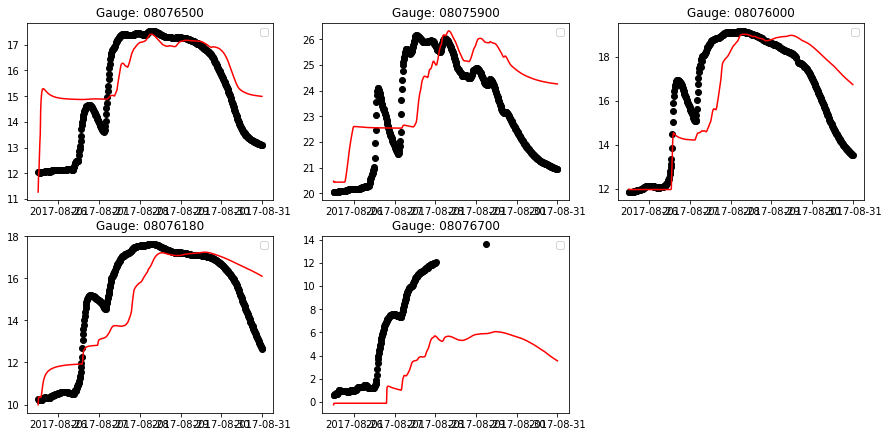

In [9]:
dr= pd.date_range('20170825120000','20170831000000', freq='0.25H')
_dr= pd.date_range('20170825120000','20170831000000', freq='0.25H')
df= pd.DataFrame(index=dr)
from scipy.stats import pearsonr
#plot stage
fig=plt.figure(figsize=(15,15))
for i in np.arange(len(gauges)):
    gauge= gauges[i,0]
    obs= pd.read_csv('/home/ZhiLi/CRESTHH/data/streamGauge/%08d.csv'%gauge, converters={'datetime':pd.to_datetime}).set_index('datetime').stage
    ax= fig.add_subplot(4,3,i+1)

    ax.legend();
    df.loc[_dr, '%08d_sim'%gauge]= sploter.stage[:,ilocs[i]]
    df.loc[:, '%08d_obs'%gauge]= obs
    ax.plot(df.index, df['%08d_obs'%gauge],'ko',label='obs')
    ax.plot(df.index, df['%08d_sim'%gauge],'r', label='sim')    
#     print gauge, pearsonr(obs, sploter.stage[:,ilocs[i]])
    ax.set_title('Gauge: %08d'%gauge)
plt.show();

ValueError: shape mismatch: value array of shape (529,) could not be broadcast to indexing result of shape (3961,)

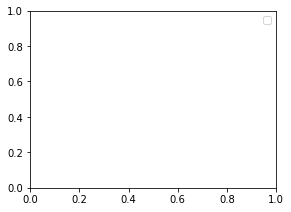

In [6]:
# dr= pd.date_range('20170825120000','20170831000000', freq='60S')
# _dr= pd.date_range('20170825120000','20170831000000', freq='120S')
df= pd.DataFrame(index=dr)
from scipy.stats import pearsonr
#plot stage
fig=plt.figure(figsize=(15,15))
for i in np.arange(len(gauges)):
    gauge= gauges[i,0]
    obs= pd.read_csv('/home/ZhiLi/CRESTHH/data/streamGauge/%08d.csv'%gauge, converters={'datetime':pd.to_datetime}).set_index('datetime').stage
    ax= fig.add_subplot(4,3,i+1)

    ax.legend();
    df.loc[_dr, '%08d_sim'%gauge]= sploter.stage[:,ilocs[i]]
    df.loc[:, '%08d_obs'%gauge]= obs
    ax.plot(df.index, df['%08d_obs'%gauge],'ko',label='obs')
    ax.plot(df.index, df['%08d_sim'%gauge],'ro', label='sim')    
#     print gauge, pearsonr(obs, sploter.stage[:,ilocs[i]])
    ax.set_title('Gauge: %08d'%gauge)
plt.show();

In [19]:
df.to_csv('../calibration/results/coupled_stage.csv')

8076500.0 [0.47804514065177506, 42.993797289007425, 55.89535082997084, Timedelta('0 days 06:15:00'), 8.016390873682967, 0.8276709107741342]
8075900.0 [-0.5301913405217134, 142.46161691021732, 173.49090458726124, Timedelta('-1 days +04:45:00'), -0.6769265184138806, 0.5496313458508013]
8076000.0 [0.10066974817185381, 232.42307954505782, 339.3394452335922, Timedelta('-1 days +20:15:00'), -0.393136704674126, 0.6524719924049455]
8076180.0 [-0.05467651923302186, 203.91335326408208, 431.56793399632477, Timedelta('-1 days +20:45:00'), 0.7708200997048885, 0.6743173282515755]
8076700.0 [0.7633928740578914, 427.94519051226075, 1602.227637585325, Timedelta('-1 days +02:00:00'), -0.09780866422911276, 0.9246434942530117]


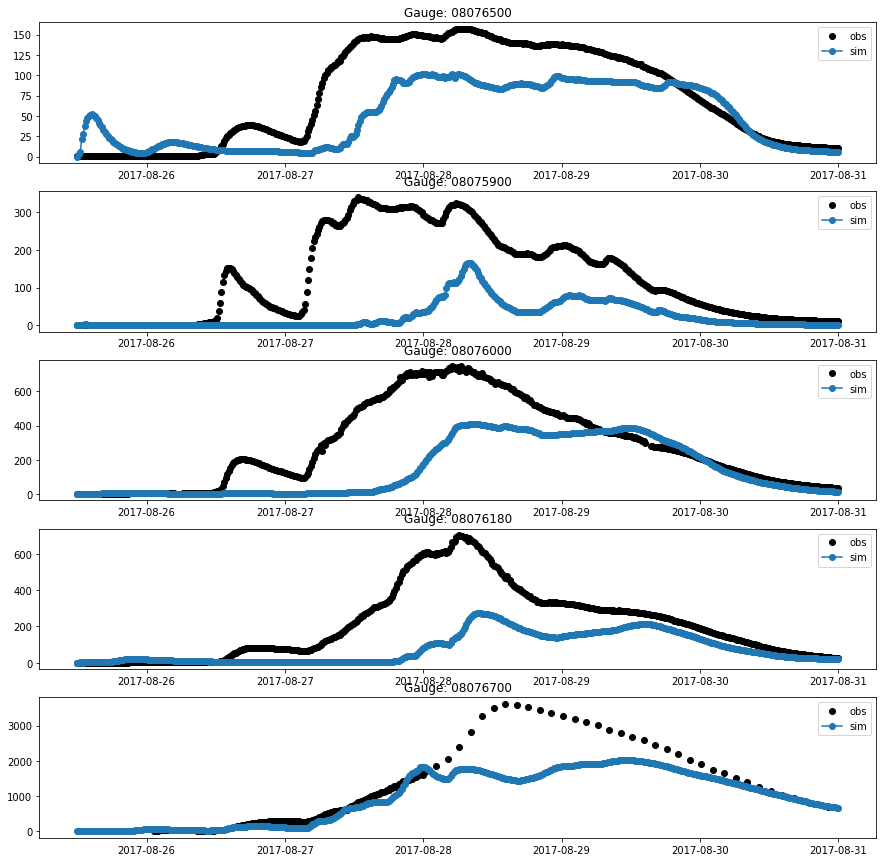

In [10]:
from scipy.stats import pearsonr
dr= pd.date_range('20170825120000','20170831000000', freq='0.25H')
_dr= pd.date_range('20170825120000','20170831000000', freq='0.25H')
df= pd.DataFrame(index=dr)
#plot stage
fig=plt.figure(figsize=(15,15))
for i in np.arange(len(gauges)):
    gauge= gauges[i,0]
    obs_Q= pd.read_csv('/home/ZhiLi/CRESTHH/data/streamGauge/%08d.csv'%gauge, converters={'datetime':pd.to_datetime}).set_index('datetime').discharge
    sim= sploter.stage[:,ilocs[i]]
    crosssection= gpd.read_file('/home/ZhiLi/CRESTHH/data/crosssection/%08d.shp'%gauge)
    area=np.array([flow_area(samples=crosssection, stage=stage) for stage in sim])
    sim_Q= sploter.speed[:,ilocs[i]] * area
    df.loc[_dr,'%08d_sim'%gauge]= sim_Q
    df.loc[:, '%08d_obs'%gauge]= obs_Q
    ax= fig.add_subplot(5,1,i+1)
    ax.plot(df['%08d_obs'%gauge].index, df['%08d_obs'%gauge], 'ko',label='obs')
    ax.plot(df['%08d_sim'%gauge].index, df['%08d_sim'%gauge], 'o-',label='sim')
    ax.legend();
    print gauge, metrics(df['%08d_obs'%gauge], df['%08d_sim'%gauge], ['nse','rmse','peak_flow_error', 'peak_time_error','bias','pearsonr'])
    ax.set_title('Gauge: %08d'%gauge);
plt.show();

8076500.0 [0.7080455279059026, 32.16450508004016, 3.1020204166644874, Timedelta('0 days 18:00:00'), 9.996583002233447, 0.8486815764460095]
8075900.0 [0.7048328601473065, 62.57314487380984, -42.07237857171771, Timedelta('-1 days +23:30:00'), -0.34075517541079237, 0.9170435761467838]
8076000.0 [0.9102838562675526, 73.31151584549396, 71.53128803477273, Timedelta('0 days 10:30:00'), 0.0037170289563023644, 0.954783747775256]
8076180.0 [0.7735498223127417, 94.54577001567614, 65.51479402721338, Timedelta('0 days 07:30:00'), 1.3290605771898532, 0.9065920798106891]
8076700.0 [0.9535490141585735, 103.90607784445471, 36.8897144709299, Timedelta('0 days 00:00:00'), 0.18829736303318897, 0.9868814074476746]


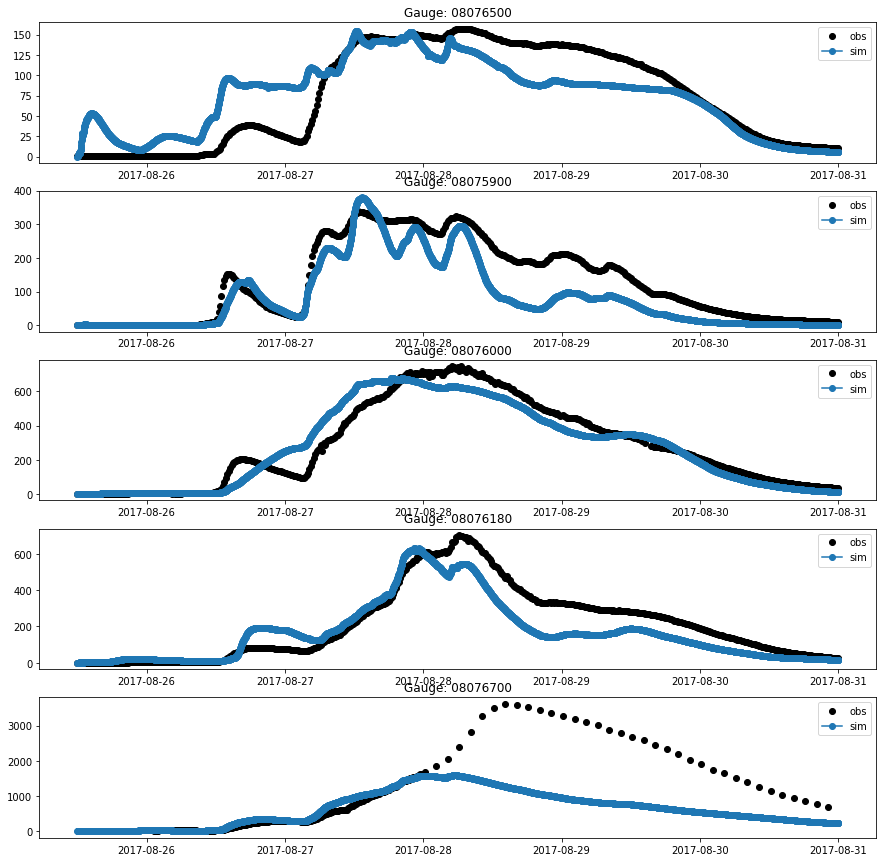

In [95]:
from scipy.stats import pearsonr
dr= pd.date_range('20170825120000','20170831000000', freq='60S')
_dr= pd.date_range('20170825120000','20170831000000', freq='120S')
df= pd.DataFrame(index=dr)
#plot stage
fig=plt.figure(figsize=(15,15))
for i in np.arange(len(gauges)):
    gauge= gauges[i,0]
    obs_Q= pd.read_csv('/home/ZhiLi/CRESTHH/data/streamGauge/%08d.csv'%gauge, converters={'datetime':pd.to_datetime}).set_index('datetime').discharge
    sim= sploter.stage[:,ilocs[i]]
    crosssection= gpd.read_file('/home/ZhiLi/CRESTHH/data/crosssection/%08d.shp'%gauge)
    area=np.array([flow_area(samples=crosssection, stage=stage) for stage in sim])
    sim_Q= sploter.speed[:,ilocs[i]] * area
    df.loc[_dr,'%08d_sim'%gauge]= sim_Q
    df.loc[:, '%08d_obs'%gauge]= obs_Q
    ax= fig.add_subplot(5,1,i+1)
    ax.plot(df['%08d_obs'%gauge].index, df['%08d_obs'%gauge], 'ko',label='obs')
    ax.plot(df['%08d_sim'%gauge].index, df['%08d_sim'%gauge], 'o-',label='sim')
    ax.legend();
    print gauge, metrics(df['%08d_obs'%gauge], df['%08d_sim'%gauge], ['nse','rmse','peak_flow_error', 'peak_time_error','bias','pearsonr'])
    ax.set_title('Gauge: %08d'%gauge);
plt.show();

In [60]:
df.to_csv('../calibration/results/coupled_discharge.csv')

8076500.0 [0.7064742071085347, 32.22506636269802, 2.5909254760542524, Timestamp('2017-08-26 06:06:00', freq='120S'), 10.100179019745106, 0.8479078870257312]
8075900.0 [0.7035837138789702, 62.65970866907093, -42.81100799173839, Timestamp('2017-08-25 11:38:00', freq='120S'), -0.3348791836039536, 0.9168493843669121]
8076000.0 [0.3239636354979253, 200.5995296880671, 423.02255294212654, Timestamp('2017-08-25 22:18:00', freq='120S'), -0.3491001587502206, 0.952526868927185]
8076180.0 [0.7723667790985772, 94.77508465229957, 63.71722261577327, Timestamp('2017-08-25 19:32:00', freq='120S'), 1.3395755582808018, 0.9062107421905227]
8076700.0 [0.8180085806942653, 203.72736611742562, -57.83675288087716, Timestamp('2017-08-25 19:28:00', freq='120S'), 0.06712679712980534, 0.9153891790954786]


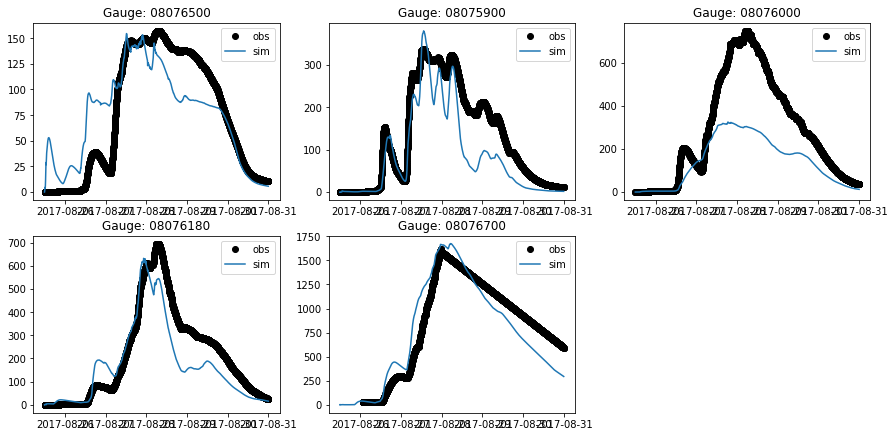

In [53]:
from scipy.stats import pearsonr

dr= pd.date_range('20170825120000','20170831000000', freq='120S')
#plot stage
fig=plt.figure(figsize=(15,15))
for i in np.arange(len(gauges)):
    gauge= gauges[i,0]
    obs_Q= pd.read_csv('/home/ZhiLi/CRESTHH/data/streamGauge/%08d.csv'%gauge, converters={'datetime':pd.to_datetime}).set_index('datetime').discharge.resample('120S',label='right').\
            interpolate().loc[dr]
    sim= sploter.stage[:,ilocs[i]]
    crosssection= gpd.read_file('/home/ZhiLi/CRESTHH/data/crosssection_new/%08d.shp'%gauge)
    area=np.array([flow_area(samples=crosssection, stage=stage) for stage in sim])
    sim_Q= sploter.speed[:,ilocs[i]] * area
    ax= fig.add_subplot(4,3,i+1)
    ax.plot(obs_Q.index, obs_Q, 'ko',label='obs')
    ax.plot(obs_Q.index, sim_Q, label='sim')
    ax.legend();
    print gauge, metrics(obs_Q, sim_Q, ['nse','rmse','peak_flow_error', 'peak_time_error','bias','pearsonr'])
    ax.set_title('Gauge: %08d'%gauge);
plt.show();

In [67]:
crosssection= gpd.read_file('/home/ZhiLi/CRESTHH/data/crosssection/08076700.shp')

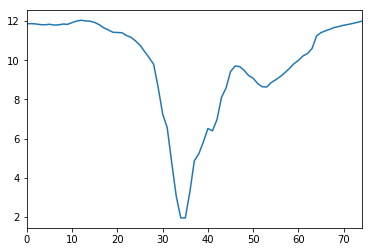

In [71]:
crosssection.Value.plot()

<Figure size 1080x576 with 0 Axes>

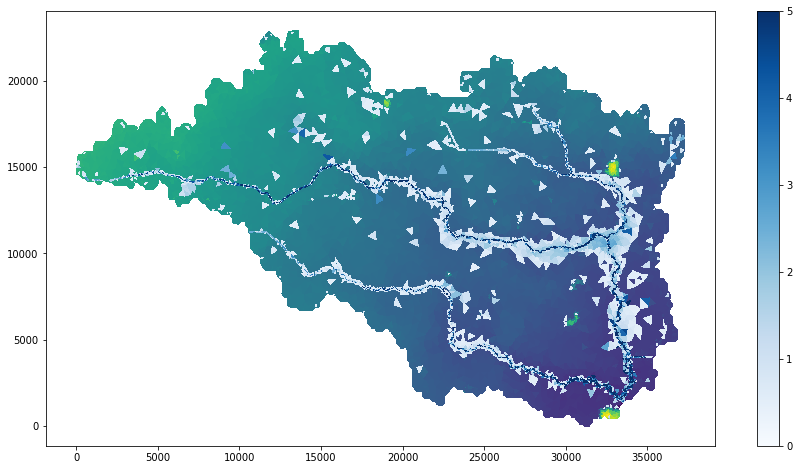

In [12]:
plt.figure(figsize=(15,8))
sploter.triang.set_mask(sploter.depth.max(axis=0) > 0.5)
plt.tripcolor(sploter.triang,
              facecolors=sploter.elev,
              cmap='viridis')
sploter.triang.set_mask(sploter.depth.max(axis=0) <= 0.5)
plt.tripcolor(sploter.triang, 
              facecolors=(sploter.depth).max(axis=0),
              cmap='Blues',
             vmin=0,
             vmax=5)
plt.colorbar()

<Figure size 1080x576 with 0 Axes>

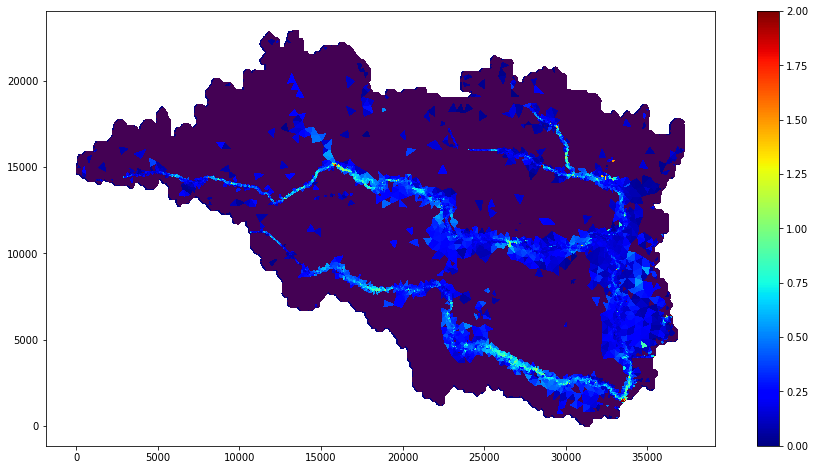

In [13]:
plt.figure(figsize=(15,8))
sploter.triang.set_mask(sploter.depth.max(axis=0) > 0.5)
plt.tripcolor(sploter.triang,
              facecolors=sploter.elev,
              cmap='viridis')
sploter.triang.set_mask(sploter.depth.max(axis=0) <= 0.5)
plt.tripcolor(sploter.triang, 
              facecolors=(sploter.speed).max(axis=0),
              cmap='jet',
             vmin=0,
             vmax=2)
plt.colorbar()

# non-coupled

In [4]:
sploter= SWW_plotter('../calibration/noncoupled_opt.sww', start_time=pd.to_datetime('20170825120000'))

Figure files for each frame will be stored in _plot


ValueError: shape mismatch: value array of shape (529,) could not be broadcast to indexing result of shape (3961,)

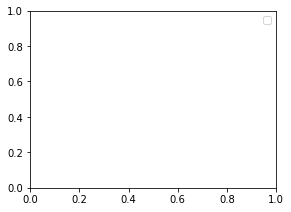

In [8]:
dr= pd.date_range('20170825120000','20170831000000', freq='60S')
_dr= pd.date_range('20170825120000','20170831000000', freq='120S')
df= pd.DataFrame(index=dr)
from scipy.stats import pearsonr
#plot stage
fig=plt.figure(figsize=(15,15))
for i in np.arange(len(gauges)):
    gauge= gauges[i,0]
    obs= pd.read_csv('/home/ZhiLi/CRESTHH/data/streamGauge/%08d.csv'%gauge, converters={'datetime':pd.to_datetime}).set_index('datetime').stage
    ax= fig.add_subplot(4,3,i+1)

    ax.legend();
    df.loc[_dr, '%08d_sim'%gauge]= sploter.stage[:,ilocs[i]]
    df.loc[:, '%08d_obs'%gauge]= obs
    ax.plot(df.index, df['%08d_obs'%gauge],'ko',label='obs')
    ax.plot(df.index, df['%08d_sim'%gauge],'ro', label='sim')    
#     print gauge, pearsonr(obs, sploter.stage[:,ilocs[i]])
    ax.set_title('Gauge: %08d'%gauge)
plt.show();

In [98]:
df.to_csv('../calibration/results/noncoupled_stage.csv')

8076500.0 [0.5523289070481039, 39.82894778336775, -26.112490402214576, Timedelta('0 days 18:00:00'), 18.286889815799803, 0.8154771616542715]
8075900.0 [0.809178593731346, 50.31153007866466, -87.3435052628468, Timedelta('-1 days +23:30:00'), 0.2875328335981639, 0.9106891391495274]
8076000.0 [0.626013537765244, 149.68036764782912, 45.898713337895856, Timedelta('0 days 10:30:00'), 0.8774985301147874, 0.8708058598770848]
8076180.0 [0.7307818475443162, 103.08795872475969, -28.60544926239038, Timedelta('0 days 08:30:00'), 2.9666814206451964, 0.8666014437183293]
8076700.0 [0.406100901843348, 371.53507243588, -238.1845944895913, Timedelta('0 days 00:00:00'), 1.4455176888672185, 0.9653753357237612]


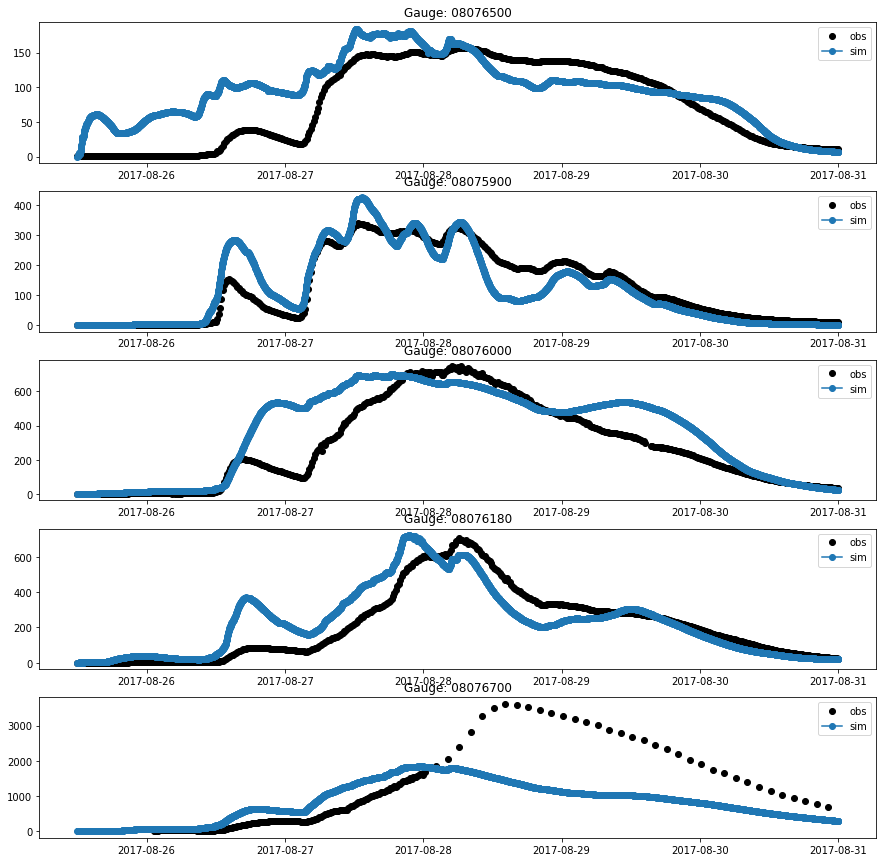

In [99]:
from scipy.stats import pearsonr
dr= pd.date_range('20170825120000','20170831000000', freq='60S')
_dr= pd.date_range('20170825120000','20170831000000', freq='120S')
df= pd.DataFrame(index=dr)
#plot stage
fig=plt.figure(figsize=(15,15))
for i in np.arange(len(gauges)):
    gauge= gauges[i,0]
    obs_Q= pd.read_csv('/home/ZhiLi/CRESTHH/data/streamGauge/%08d.csv'%gauge, converters={'datetime':pd.to_datetime}).set_index('datetime').discharge
    sim= sploter.stage[:,ilocs[i]]
    crosssection= gpd.read_file('/home/ZhiLi/CRESTHH/data/crosssection/%08d.shp'%gauge)
    area=np.array([flow_area(samples=crosssection, stage=stage) for stage in sim])
    sim_Q= sploter.speed[:,ilocs[i]] * area
    df.loc[_dr,'%08d_sim'%gauge]= sim_Q
    df.loc[:, '%08d_obs'%gauge]= obs_Q
    ax= fig.add_subplot(5,1,i+1)
    ax.plot(df['%08d_obs'%gauge].index, df['%08d_obs'%gauge], 'ko',label='obs')
    ax.plot(df['%08d_sim'%gauge].index, df['%08d_sim'%gauge], 'o-',label='sim')
    ax.legend();
    print gauge, metrics(df['%08d_obs'%gauge], df['%08d_sim'%gauge], ['nse','rmse','peak_flow_error', 'peak_time_error','bias','pearsonr'])
    ax.set_title('Gauge: %08d'%gauge);
plt.show();

In [11]:
df.to_csv('../calibration/results/infiltration_discharge.csv')

In [127]:
samples=gpd.read_file('/home/ZhiLi/CRESTHH/data/crosssection_new/08076180.shp')

In [101]:
from cresthh.anuga.file.netcdf import NetCDFFile
nc= NetCDFFile('../calibration/coupled_opt.sww')

In [15]:
pd.date_range('20170825120000','20170831000000', freq='0.25H').get_loc('201708290300')

348

In [18]:
from cresthh.anuga.file_conversion.sww2dem import sww2dem

sww2dem('../calibration/Harvey_coupled.sww','../calibration/results/depth_max_new.asc', quantity='depth', verbose=True, reduction=max)

Reading from ../calibration/Harvey_coupled.sww
Output directory is ../calibration/results/depth_max_new.asc
------------------------------------------------
Statistics of SWW file:
  Name: ../calibration/Harvey_coupled.sww
  Reference:
    Lower left corner: [250757.348812, 3301330.019378]
    Start time: 0.000000
  Extent:
    x [m] in [0.000000, 37293.972656], len(x) == 45194
    y [m] in [0.000000, 22885.353516], len(y) == 45194
    t [s] in [0.000000, 475200.000000], len(t) == 529
  Quantities [SI units]:
Slicing sww file, num points: 45194, block size: 10000
Processed values for stage-elevation are in [0.038998, 8.580938]
Creating grid
Interpolated values are in [nan, nan]
Writing ../calibration/results/depth_max_new.prj
Writing ../calibration/results/depth_max_new.asc
Doing row 0 of 2289
Doing row 229 of 2289
Doing row 458 of 2289
Doing row 687 of 2289
Doing row 916 of 2289
Doing row 1145 of 2289
Doing row 1374 of 2289
Doing row 1603 of 2289
Doing row 1832 of 2289
Doing row 2061 

'../calibration/results/depth_max_new'

In [30]:
from cresthh.anuga.utilities.animate import SWW_plotter

splotter=SWW_plotter('../Sensitivity/temp.sww')

Figure files for each frame will be stored in _plot


In [ ]:
splotter.save_asc_file('test.asc', 'depth', )

In [24]:
dr= pd.date_range('20170825120000', '20170831000000', freq='120S')

In [9]:
coupled= processSWW('opt_Harvey.sww',['stage','depth','speed'],(284219.573  , 3302832.615),start_time=pd.to_datetime('20170825120000'))

Figure files for each frame will be stored in _plot


In [11]:
crossSection= gpd.read_file('/home/ZhiLi/CRESTHH/data/crosssection/08076700.shp')
coupled['area']= coupled.apply(lambda x: flow_area(crossSection, x.stage), axis=1)

In [12]:
coupled['Q']= coupled.area * coupled.speed

In [35]:
obs= pd.read_csv('/home/ZhiLi/CRESTHH/data/streamGauge/08076700.csv',converters={'datetime':pd.to_datetime}).set_index('datetime')

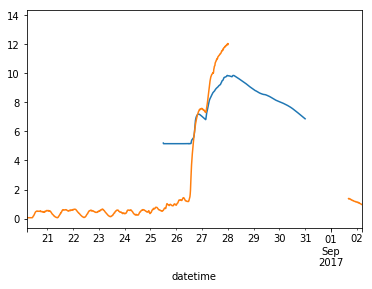

In [41]:
coupled.stage.plot()
obs.stage.plot()

,discharge,stage
datetime,,
2017-08-20 05:00:00,NaN,0.079248
2017-08-20 05:15:00,NaN,0.057912
2017-08-20 05:30:00,NaN,0.057912
2017-08-20 05:45:00,NaN,0.057912
2017-08-20 06:00:00,NaN,0.057912
2017-08-20 06:15:00,NaN,0.057912
2017-08-20 06:30:00,NaN,0.057912
2017-08-20 06:45:00,NaN,0.057912
2017-08-20 07:00:00,NaN,0.057912


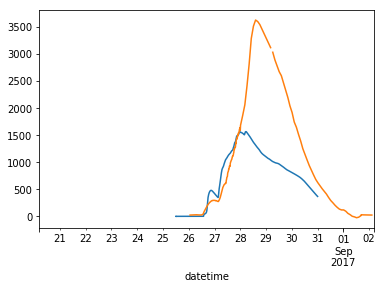

In [37]:
coupled.Q.plot()
obs.discharge.plot()

In [44]:
myProj = Proj("+proj=utm +zone=15, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
xc= sploter.xc+ sploter.xllcorner
yc= sploter.yc+ sploter.yllcorner
# initialize water depth
origin= (-95.43666, 30.11085)
origin_utm= myProj(origin[0],origin[1])
iloc= np.argmin( (xc-origin_utm[0])**2 + (yc-origin_utm[1])**2 )
# second= (-95.646063,30.11935)
# second_utm= myProj(second[0],second[1])
# dist= ((origin_utm[0]-second_utm[0])**2+ (origin_utm[1]-second_utm[1])**2)

In [15]:
period= pd.date_range('20170825','20170831', freq='120S')